Xuất phát từ thực tế là 1 bức ảnh có nhiều chi tiết thừa. Xem xét bức ảnh sau đây:

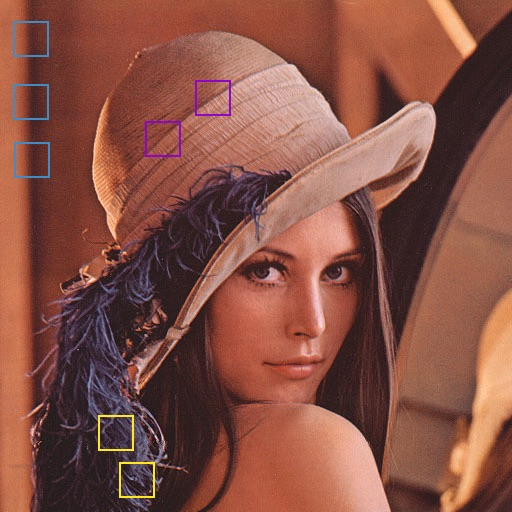

**Patchwise Implementation**

Các hình vuông cùng màu nằm trên các khu vực tương tự. Vậy tại sao không sử dụng tất cả những thông tin này để suy ra giá trị của các pixel. Ý tưởng xuất phát từ lý thuyết Trường ngẫu nhiên Markov Random Field, theo trực giác, cho cho rằng vùng lân cận của một pixel sẽ tương tự đối với các vùng lân cận tương tự.

Về cơ bản, thuật toán sửa đổi từng giá trị pixel theo giá trị trung bình có trọng số của tất cả các pixel khác và các giá trị trọng số được xác định bởi độ tương đồng vùng lân cận:

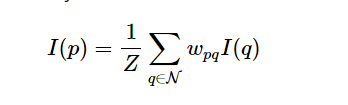


Biến $Z = \sum w_{pq}$ là hệ số chuẩn hóa và $\cal{N}$ là vùng lân cận xung quanh pixel $p$. Trọng số $w_{pq}$ được tính như sau:

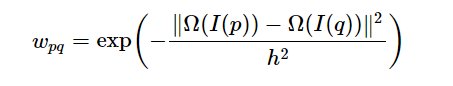

trong đó $\Omega(p)$ chỉ ra patch tâm pixel $p$ và có kích thước (2f + 1) x (2f + 1)

In [ ]:
#import các thư viện cần thiết
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.color as color
from skimage import data_dir
from skimage.transform import resize
import time

In [ ]:
#load hình ảnh và khởi tạo nhiễu gauss
noise_var = np.logspace(0, 2, 5)
data_dir = '/content/drive/MyDrive/TEST'
lena = io.ImageCollection(data_dir + "/lena.png")[0].astype(np.float) / 255.0
#giảm chiều dữ liệu, chuyển từ ảnh màu sang ảnh xám
lena = resize(lena, (lena.shape[0]/2, lena.shape[1]/2, lena.shape[2] - 1))
#chuyển hệ màu sang hệ lab 
lena = color.rgb2lab(lena)

lena = lena[:,:,0]

noisy = []
for sigma2 in noise_var:
  #khởi tạo nhiễu gauss
  
    noise = np.random.normal(0, np.sqrt(sigma2), lena.shape)

    n = lena + noise
    #tránh truờng hợp overbound
    n[n > 100] = 100
    n[n < 0] = 0
    noisy.append(n)
  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


**ĐO CHẤT LƯỢNG HÌNH ẢNH**

Chúng ta cần một thước đo để đo hiệu suất của thuật toán. Ở đây chúng ta sử dụng PSNR (Tỉ số tín hiệu cực đại trên nhiễu)

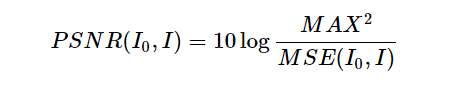

Trong đó $ I_0 $ là hình ảnh ban đầu của chúng ta và $ I $ là hình ảnh bị biến dạng. $ MAX $ là giá trị tối đa mà tín hiệu có thể nhận được. 

In [ ]:
def PSNR(original, noisy, peak=100):
    mse = np.mean((original-noisy)**2)
    return 10*np.log10(peak*peak/mse)

Dưới đây là một số hình ảnh với lượng nhiễu khác nhau:

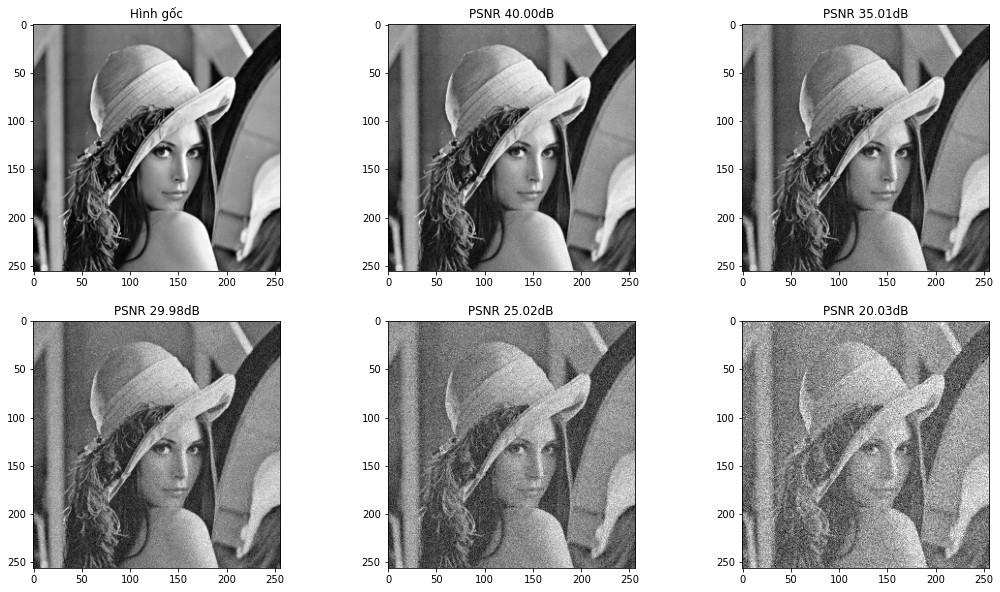

In [ ]:
#show hình ảnh có nhiễu
plt.figure(figsize=(18,10)) 

plt.subplot(2,3,1)
plt.imshow(lena,cmap='gray')
plt.title("Hình gốc")
for i,n in enumerate(noisy):
    plt.subplot(2,3,i+2)
    plt.title("PSNR {0:.2f}dB".format(PSNR(lena, n)))
    plt.imshow(n,cmap='gray')

Hình ảnh có PSNR càng cao thì hình ảnh càng chất lượng hơn

**Triển khai**

Theo định nghĩa thuật toán, chúng ta có thể dịch trực tiếp các phép toán trong thuật toán NLM thành code, bằng cách:

- Lặp từng pixel $p$.

- Với mỗi $p$ tiếp tục lặp tất cả pixel $q$ để so sánh patch.
- Lặp từng patch tâm $q$ tới patch tâm $p$.
- Tính $Z = \sum w_{pq}$ và $w_{pq}$.

- Cập nhật lại giá trị $p$.




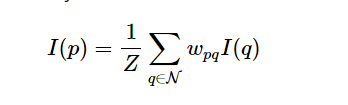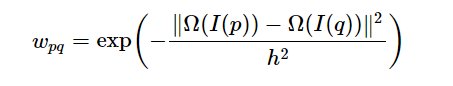

In [ ]:
from functools import reduce, partial

def _distance(values, pixel_window, h2, Nw):
    patch_window, central_diff = values
    
    diff = np.sum((pixel_window - patch_window) ** 2)
    
    #xóa khoảng cách tâm khỏi phép tính
    diff -= central_diff

    w = np.exp(-diff / (h2 * Nw))

    #trả về w * I(q) và w
    nr, nc = patch_window.shape
    #patch_windows[nr//2, nc//2]: giá trị tâm I(q)
    return w * patch_window[nr // 2, nc // 2], w

def nonlocalmeans(img, n_big=20, n_small=5, h=10):
    #khởi tạo ảnh trống
    new_n = np.zeros_like(img)

    Nw = (2 * n_small + 1) ** 2
    #h^2
    h2 = h * h
    n_rows, n_cols = img.shape

    #tính toán tọa độ trong vùng lân cận
    
    D = range(-n_big, n_big + 1)

    #tránh xét đến điểm hiện tại not (r==0) and (c==0)

    big_diff = [(r, c) for r in D for c in D if not (r == 0 and c == 0)]

    #tính toán tọa độ cho patch tìm kiếm (kích thước 2 * n_small + 1)

    small_rows, small_cols = np.indices((2 * n_small + 1, 2 * n_small + 1)) - n_small

    padding = n_big + n_small

    #đối xứng gương để trượt patch có index nằm ngoài index hợp lệ trong ma trận
    n_padded = np.pad(img, padding, mode='reflect')

    #lặp qua từng pixel
    for r in range(padding, padding + n_rows):
        for c in range(padding, padding + n_cols):
            #pixel hiện tại đang xét
            pixel_window = n_padded[small_rows + r, small_cols + c]

            #xây dựng danh sách các tọa độ của patch
            windows = [n_padded[small_rows + r + d[0], small_cols + c + d[1]] for d in big_diff]

            #xây dựng danh sách các điểm lân cận
            central_diffs = [(n_padded[r, c] - n_padded[r + d[0], c + d[1]]) for d in big_diff]
            #trả về w*I(q) và w
            distance_map = partial(_distance, pixel_window=pixel_window, h2=h2, Nw=Nw)
            #tính từng w*I(q) và w
            distances = map(distance_map, zip(windows, central_diffs))
            #total_w: tổng trọng số, total_c: sum (w * I(q))
            total_c, total_w = reduce(lambda a, b: (a[0] + b[0], a[1] + b[1]), distances)
            #cập nhật lại giá trị pixel
            new_n[r - padding, c - padding] = total_c / total_w

    return new_n

**Ước tính nhiễu (Sigma)**

Chúng ta đã có tất cả thứ cần dùng để khử nhiễu ảnh bằng NLM. Nhưng chúng ta vẫn chưa hiểu về những tham số. Tại sao n_big = 20, n_small = 5 và h = 10? Đây là giải thích và một vài cải tiến.

n_big: liên quan đến vùng lân cận để tìm kiếm patch. Càng lớn, càng tốt nhưng càng tiêu tốn nhiều tài nguyên CPU.

n_small: liên quan đến kích thước patch khi so sánh lân cận tương tự. Chúng ta không thể chọn patch quá lớn vì các patch sẽ khác nhau, chúng ta cũng không thể chọn patch quá nhỏ vì các patch sẽ giống nhau. Chúng ta thường chọn từ 3 đến 10.

h: đây là hằng số sử dụng để kiểm soát sự khác biệt giữa các patch. Nó có liên quan chặt chẽ đến phương sai nhiễu $\sigma^2$ hiện diện trên hình ảnh, và nó có thể phụ thuộc từ pixel này sang pixel khác. Thông thường nó bằng $K\sigma$ trong đó K $(7,10)$.



Sau đây là code để ước tính $\widehat{\sigma}$ sử dụng hồi quy tuyến tính:

In [ ]:
def estimate_noise(img):
    #bỏ 2 dòng cuối và các phần tử trái phải ma trận
    upper = img[:-2, 1:-1].flatten()
    #bỏ 2 dòng đầu và các phần tử trái phải ma trận
    lower = img[2:, 1:-1].flatten()
    #bỏ 2 cột cuối và các phần tử trên dưới ma trận
    left = img[1:-1, :-2].flatten()
    #bỏ 2 cột đầu và các phần tử trên dưới ma trận
    right = img[1:-1, 2:].flatten()
    #bỏ các phần tử trái phải trên dưới ma trận
    central = img[1:-1, 1:-1].flatten()
    U = np.column_stack((upper, lower, left, right))   
    c_estimated = np.dot(U, np.dot(np.linalg.pinv(U), central))
    #mean square error
    error = np.mean((central - c_estimated)**2)
    sigma = np.sqrt(error)
    return sigma

In [ ]:
sigmas = []
for i,n in enumerate(noisy):
    sigma = estimate_noise(n)
    sigmas.append(sigma)
    print("Sigma is {0:.4f}".format(sigma))
    

Sigma is 2.0606
Sigma is 2.6695
Sigma is 3.9794
Sigma is 6.5487
Sigma is 11.2504


PSNR trước 40.0044 - PSNR sau khi giảm nhiễu 37.3717 - tốn 268.6 giây
PSNR trước 35.0083 - PSNR sau khi giảm nhiễu 36.0133 - tốn 250.5 giây
PSNR trước 29.9777 - PSNR sau khi giảm nhiễu 33.0327 - tốn 259.7 giây
PSNR trước 25.0239 - PSNR sau khi giảm nhiễu 29.0872 - tốn 268.0 giây
PSNR trước 20.0282 - PSNR sau khi giảm nhiễu 24.5672 - tốn 262.4 giây


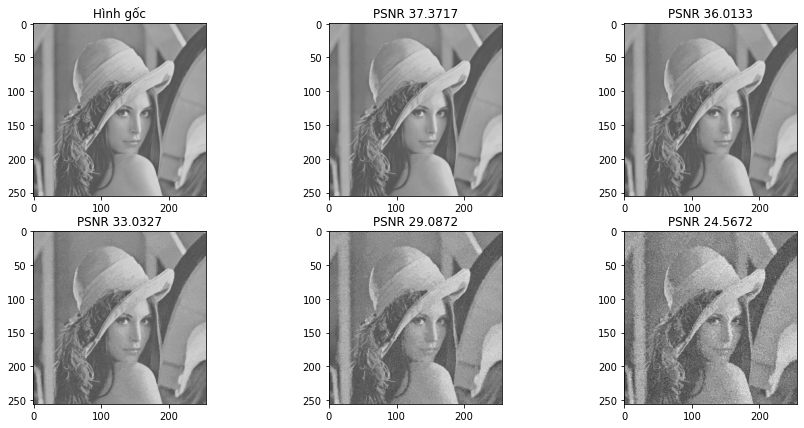

In [ ]:
denoised_naive = []
plt.figure(figsize=(15,7))
plt.subplot(2,3,1)
plt.title("Hình gốc")
plt.imshow(lena, vmin=0, vmax=100, cmap='gray')
for i,n in enumerate(noisy):
    start = time.time()
    denoised = nonlocalmeans(noisy[i], n_big=7, n_small=1, h=0.4*sigmas[i])
    end = time.time()
    secs = end-start
    denoised_naive.append(denoised)
    oPSNR = PSNR(lena, noisy[i])
    dPSNR = PSNR(lena, denoised)
    print("PSNR trước {0:.4f} - PSNR sau khi giảm nhiễu {1:.4f} - tốn {2:.1f} giây".format(oPSNR, dPSNR, secs))
    plt.subplot(2,3,i+2)
    plt.title("PSNR {0:.4f}".format(dPSNR))
    plt.imshow(denoised, vmin=0, vmax=100, cmap='gray')